In [1]:
from dataset import DictDataset, RepeatedDictDataset
from model import *
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from importlib import reload
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import wandb
import torch
import os
from loss_functions import *
from inverse_warp import inverse_warp
from utils import projective_inverse_warp


/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader

# dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
# sample = dataloader.__iter__().__next__()
# bigmodel = BigModel()
# pose_final, depth_map = bigmodel(sample)

In [3]:
repeatdataset = RepeatedDictDataset('./data/folder_0_pair_0.pt', 100)

In [4]:
import os
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

def train_model(bigmodel, 
                train_dataset, 
                val_dataset, 
                num_epochs=10, 
                batch_size=2,
                lr=1e-3,
                device='cpu',
                optimizer_cls=optim.Adam,
                patience=3,
                log_interval=10,
                save_dir="models",  # Directory to save the model
                save_name="best_model.pth"  # Model name to save
                ):
    """
    Train a model with photometric and smooth loss for depth estimation.
    """
    # Camera intrinsics
    intrinsics_flat = [9.569475e+02, 0.000000e+00, 6.939767e+02,
                       0.000000e+00, 9.522352e+02, 2.386081e+02,
                       0.000000e+00, 0.000000e+00, 1.000000e+00]

    # Move the model to the device
    bigmodel.to(device)

    # Set up data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    optimizer = optimizer_cls(bigmodel.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience_counter = 0

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, save_name)

    # Training loop
    for epoch in range(num_epochs):
        bigmodel.train()
        train_loss = 0.0

        # Use tqdm for progress tracking
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, sample in enumerate(progress_bar):
            # Zero the gradients
            optimizer.zero_grad()

            # Prepare inputs
            B = sample['image_t1']['processed_image'].shape[0]  # Batch size
            intrinsics_matrix = torch.tensor(intrinsics_flat).view(1, 3, 3).repeat(B, 1, 1).to(device)

            tgt_image = sample['image_t1']['processed_image'].to(device)  # Target image [B, 3, H, W]
            ref_image = sample['image_t']['processed_image'].to(device)  # Reference image [B, 3, H, W]

            # Forward pass
            pose, depth_map = bigmodel(sample)

            # Ensure depth_map is [B, H, W]
            if depth_map.dim() == 4:  # [B, 1, H, W]
                depth_map = depth_map.squeeze(1)  # Remove channel dimension

            # Photometric reconstruction loss
            photometric_loss = photometric_reconstruction_loss(
                tgt_img=tgt_image,
                ref_img=ref_image,
                intrinsics=intrinsics_matrix,
                depth=depth_map,
                pose=pose
            )

            # Smooth loss
            smoothness_loss = smooth_loss(depth_map.unsqueeze(1))  # Add back channel dimension

            # Total loss
            loss = photometric_loss + 0.01 * smoothness_loss

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Accumulate train loss
            train_loss += loss.item()

            if i % log_interval == 0:
                avg_loss = train_loss / (i + 1)
                progress_bar.set_postfix(loss=avg_loss)

        # Validation loop (optional, uncomment if needed)
        # bigmodel.eval()
        # val_loss = 0.0
        # with torch.no_grad():
        #     for sample in val_loader:
        #         tgt_image = sample['image_t1']['processed_image'].to(device)
        #         ref_image = sample['image_t']['processed_image'].to(device)
        #         pose, depth_map = bigmodel(sample)
        #         depth_map = depth_map.squeeze(1) if depth_map.dim() == 4 else depth_map
        #         photometric_loss = photometric_reconstruction_loss(
        #             tgt_img=tgt_image,
        #             ref_img=ref_image,
        #             intrinsics=intrinsics_matrix,
        #             depth=depth_map,
        #             pose=pose
        #         )
        #         smoothness_loss = smooth_loss(depth_map.unsqueeze(1))
        #         val_loss += (photometric_loss + 0.01 * smoothness_loss).item()
        #
        # val_loss /= len(val_loader)
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     patience_counter = 0
        #     torch.save(bigmodel.state_dict(), save_path)
        # else:
        #     patience_counter += 1

        # if patience_counter >= patience:
        #     print("Early stopping triggered!")
        #     break

In [5]:
big = BiggerModel()
train_model(bigmodel = big,
            train_dataset = repeatdataset,
            val_dataset = repeatdataset)

Epoch 10/10: 100%|██████████| 50/50 [00:07<00:00,  6.38it/s, loss=0.000146]


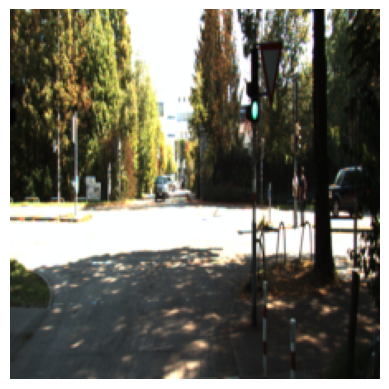

In [6]:
import matplotlib.pyplot as plt
image = repeatdataset[0]['image_t']['processed_image']
# Convert the tensor to a NumPy array

# Convert the tensor to a NumPy array
image_array = image.permute(1, 2, 0).cpu().numpy()  # Shape: [224, 224, 3]

# If the image is normalized, undo the normalization (example for ImageNet stats)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_array = image_array * std + mean  # Denormalize
image_array = image_array.clip(0, 1)  # Clip values to valid range [0, 1]

# Display the image using Matplotlib
plt.imshow(image_array)
plt.axis('off')  # Turn off axis
plt.show()

torch.Size([1, 224, 224])


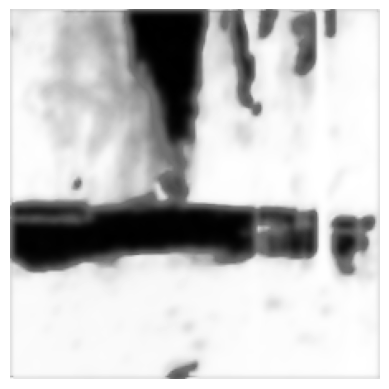

In [7]:
import matplotlib.pyplot as plt

train_loader = DataLoader(repeatdataset, batch_size=1, shuffle=True)
sample = train_loader.__iter__().__next__()
pose, depth_map = big(sample)
print(depth_map[0].shape)
image_array = depth_map[0].permute(1, 2, 0).cpu().detach().numpy()  # Shape: [224, 224, 1]

# If the image is normalized, undo the normalization (example for ImageNet stats)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_array = image_array * std[0] + mean[0]  # Denormalize (assuming single channel depth map)
image_array = image_array.clip(0, 1)  # Clip values to valid range [0, 1]

# Display the image using Matplotlib
plt.imshow(image_array, cmap='gray')  # Use grayscale colormap for depth map
plt.axis('off')  # Turn off axis
plt.show()